In [1]:
import os
import pandas as pd
def load(path): 
    target = []
    list_dir = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            diri = os.path.join(dirname, filename)
            list_dir.append(diri)
            target.append(1)
    print("mission completed!! upload   " + str(len(target))+ '  file')
    data = pd.DataFrame({"target":target,"path": list_dir}) 
    return data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    load("../input/architecture-dataset/arcDataset"),
    x_col='path',
    y_col='target',
    target_size=(256, 256),
    batch_size=9588//4,
    shuffle=True,
    class_mode="raw")

mission completed!! upload   4799  file
Found 4794 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [3]:
import tensorflow.keras as keras
import tensorflow as tf

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [4]:
codings_size = 100
inputs = keras.layers.Input(shape=[256, 256,3])

z = keras.layers.Conv2D(
                filters=32, kernel_size=(3,3), strides=(2, 2), activation='relu')(inputs)
z = keras.layers.Conv2D(
                filters=64, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Conv2D(
                filters=128, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Conv2D(
                filters=256, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
 inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [5]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(units=16*2*16*2*32, activation="relu")(decoder_inputs)
x = keras.layers.Reshape(target_shape=(16*2, 16*2, 32))(x)
x = keras.layers.Conv2DTranspose(
                filters=64*4, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64*2, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=3, kernel_size=(3,3), strides=1, padding='same',activation="sigmoid")(x)
outputs = keras.layers.Reshape([256,256,3],input_shape=[256,256,3])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [6]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [7]:
import numpy as np
latent_loss = -0.5 * tf.math.reduce_sum(
 1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
 axis=-1)
variational_ae.add_loss(tf.math.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [8]:
import torch 
torch.cuda.get_device_name()
variational_ae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 100), (None, 11908616    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  3754115     model[0][2]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 896         input_1[0][0]                    
____________________________________________________________________________________________

In [9]:
history = variational_ae.fit(test_generator[0][1], test_generator[0][1], epochs=100, batch_size=64)

Epoch 1/100
38/38 [==============================] - 29s 397ms/step - loss: 0.6932
Epoch 2/100
38/38 [==============================] - 14s 370ms/step - loss: 0.6709
Epoch 3/100
38/38 [==============================] - 14s 370ms/step - loss: 0.6573
Epoch 4/100
38/38 [==============================] - 14s 372ms/step - loss: 0.6525
Epoch 5/100
38/38 [==============================] - 14s 372ms/step - loss: 0.6485
Epoch 6/100
38/38 [==============================] - 14s 377ms/step - loss: 0.6477
Epoch 7/100
38/38 [==============================] - 14s 371ms/step - loss: 0.6464
Epoch 8/100
38/38 [==============================] - 14s 377ms/step - loss: 0.6469
Epoch 9/100
38/38 [==============================] - 14s 371ms/step - loss: 0.6458
Epoch 10/100
38/38 [==============================] - 14s 367ms/step - loss: 0.6448
Epoch 11/100
38/38 [==============================] - 14s 376ms/step - loss: 0.6411
Epoch 12/100
38/38 [==============================] - 14s 367ms/step - loss: 0.6413
E

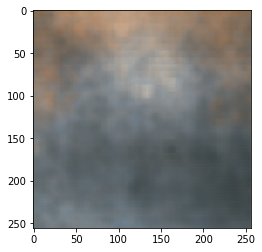

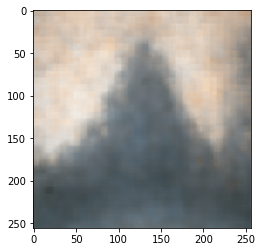

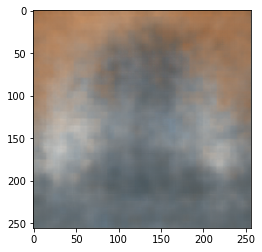

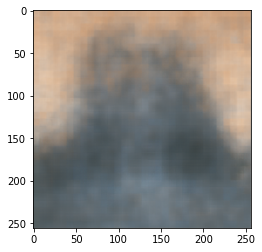

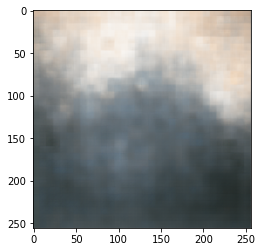

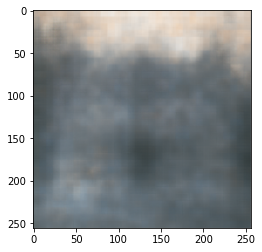

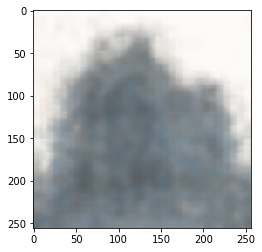

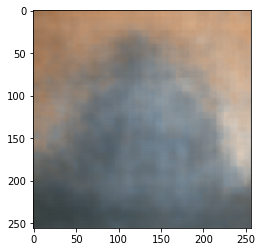

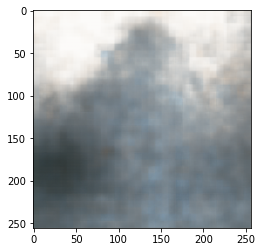

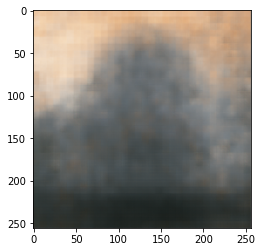

In [15]:
import cv2
import matplotlib.pyplot as plt
codings = tf.random.normal(shape=[10, codings_size])
images = variational_decoder(codings).numpy()
p = 0
for i in images:
    p += 1
    plt.figure()
    plt.imshow(cv2.cvtColor(np.reshape(i,(256,256,3)),cv2.COLOR_RGB2BGR))  
    plt.savefig("./del" + str(p) +".jpeg")
    